In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_mkv_sinlog_config
from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_LSTM_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_lstm_sinlog_config
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_mkv_bipot_config
from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_lstm_bipot_config
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_mkv_quadsin_config
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config as get_lstm_quadsin_config

In [2]:
mkv_sinlog_config = get_mkv_sinlog_config()
mkv_bipot_config = get_mkv_bipot_config()
mkv_quadsin_config = get_mkv_quadsin_config()
lstm_sinlog_config = get_lstm_sinlog_config()
lstm_bipot_config = get_lstm_bipot_config()
lstm_quadsin_config = get_lstm_quadsin_config()
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
def plot_drift_estimator(config,root_dir, mean, mean_min, mean_max, numpy_Xs, true_drift, Nepoch, dirname, label, toSave: bool = True):
    if "BiPot" in config.data_path:
        ts_type_str = "fBiPot"
    elif "SinLog" in config.data_path:
        ts_type_str = "fSinLog"
    elif "QuadSinHF" in config.data_path:
        ts_type_str = "fQuadSinHF2"
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.scatter(numpy_Xs, true_drift, color="red", label="True Drift")
    ymin = mean - mean_min
    ymax = mean_max - mean
    ymin[ymin < 0.] = 0.
    ymax[ymax < 0.] = 0.
    plt.errorbar(numpy_Xs, mean, yerr=[ymin, ymax], xerr=None, fmt='o', color="blue", alpha=0.4)
    plt.scatter(numpy_Xs, mean, label="Estimated Drift", color="blue")
    ax.set_title(rf"Score Estimator for {label} {'with LSTM' if 'LSTM' in config.scoreNet_trained_path else ''}", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $Y$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    if toSave:
        plt.savefig((root_dir +f"DiffusionModelPresentationImages/TSPM_Markovian/{dirname}/TSPM_MLP_PM_ST_{ts_type_str}_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFac").replace(
                ".", "") + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

In [4]:
def get_best_epoch(type):
    model_dir = "/".join(config.scoreNet_trained_path.split("/")[:-1]) + "/"
    for file in os.listdir(model_dir):
        if config.scoreNet_trained_path in os.path.join(model_dir, file) and f"{type}" in file:
            print(file.split(f"{type}NEp")[-1])
            best_epoch = int(file.split(f"{type}NEp")[-1])
    return best_epoch

def get_best_eval_file(root_score_dir, ts_type, best_epoch_eval):
    for file in os.listdir(root_score_dir):
        if ("_"+str(best_epoch_eval)+"Nep") in file and "muhats" in file and ts_type in file:
            return np.load(root_score_dir+file, allow_pickle=True)

def eval_exp_pipeline(root_score_dir, ts_type, config, root_dir, Xs, toSave, label, true_drifts):
    best_epoch_eval = get_best_epoch(type="Trk")
    muhats = get_best_eval_file(root_score_dir=root_score_dir, best_epoch_eval = best_epoch_eval, ts_type=ts_type)
    muhats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[2]*1)
    print(muhats.shape)
    mu_hats = muhats.mean(axis=-1)
    mu_hats_minq = np.quantile(muhats, axis=-1, q=0.005) # Lower bound
    mu_hats_maxq = np.quantile(muhats, axis=-1, q=0.995) # Upper boun
    plot_drift_estimator(root_dir=root_dir, config=config, mean=mu_hats, mean_min=mu_hats_minq, mean_max=mu_hats_maxq, dirname=ts_type, numpy_Xs=Xs,  toSave=toSave, true_drift=true_drifts, Nepoch=best_epoch_eval, label=label)
    return np.mean(np.power(mu_hats - true_drifts, 2))

11636
(256, 100)


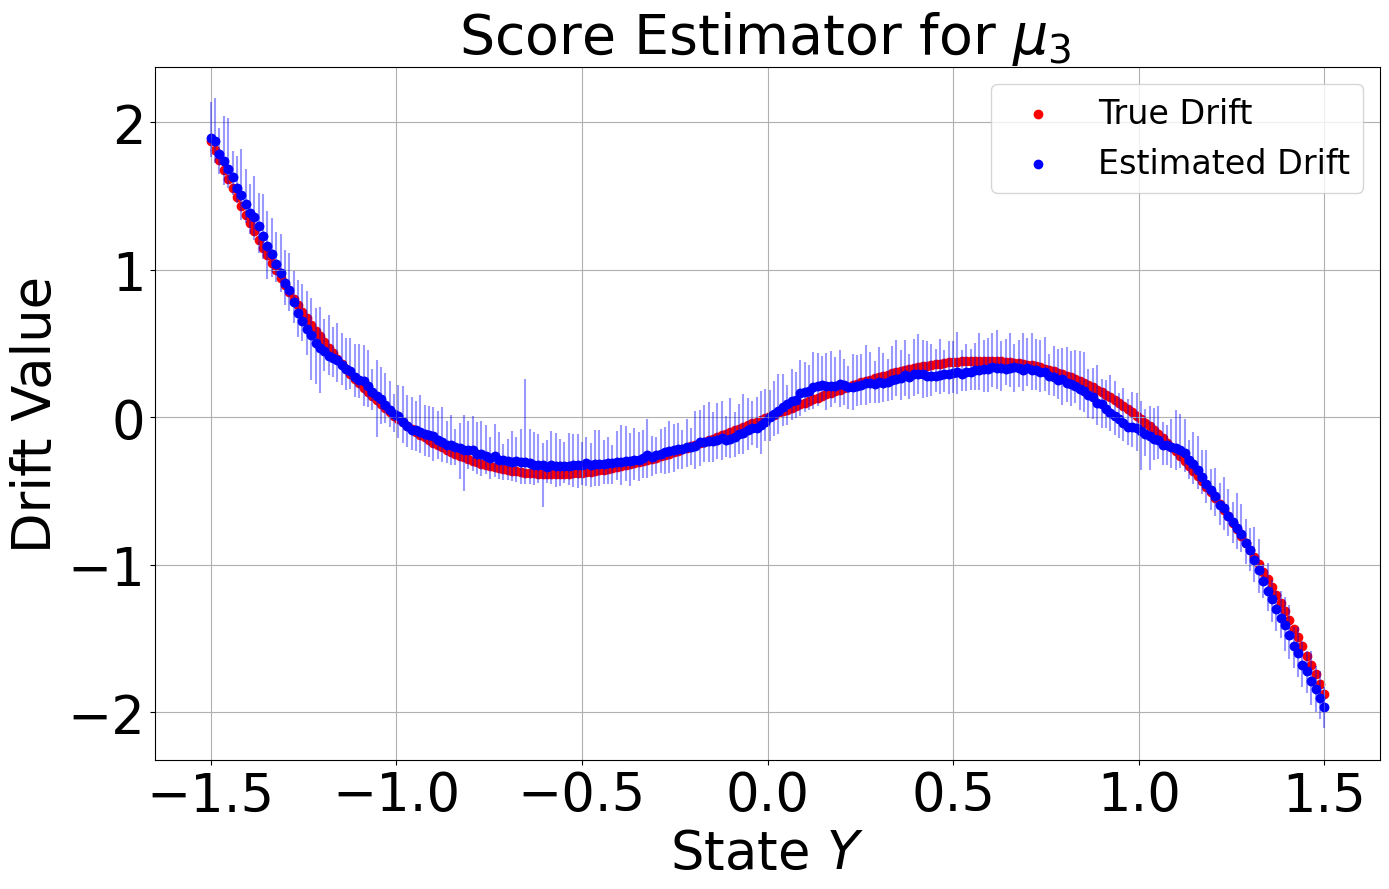

2680
(256, 100)


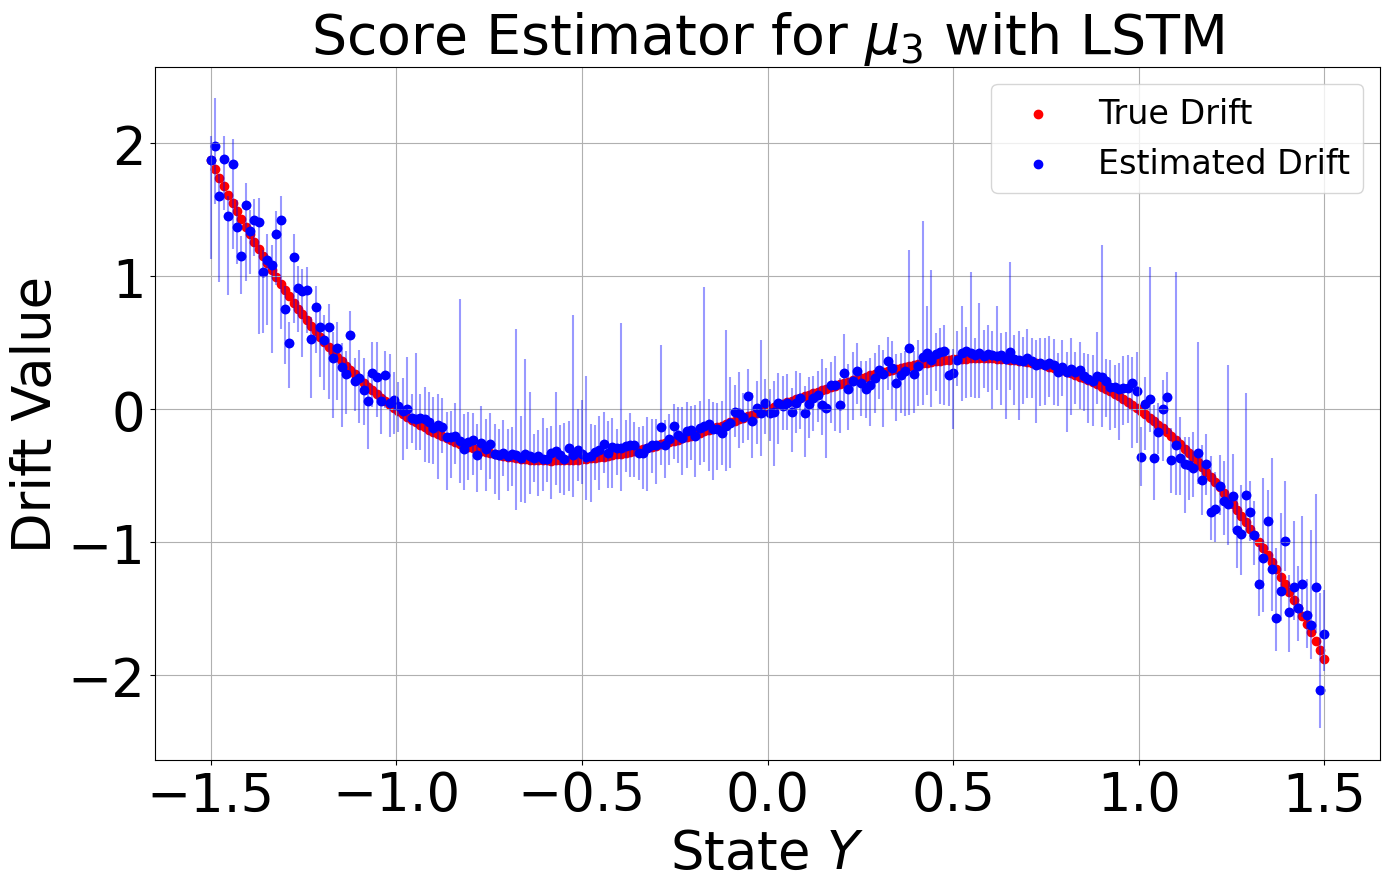

1398
(256, 100)


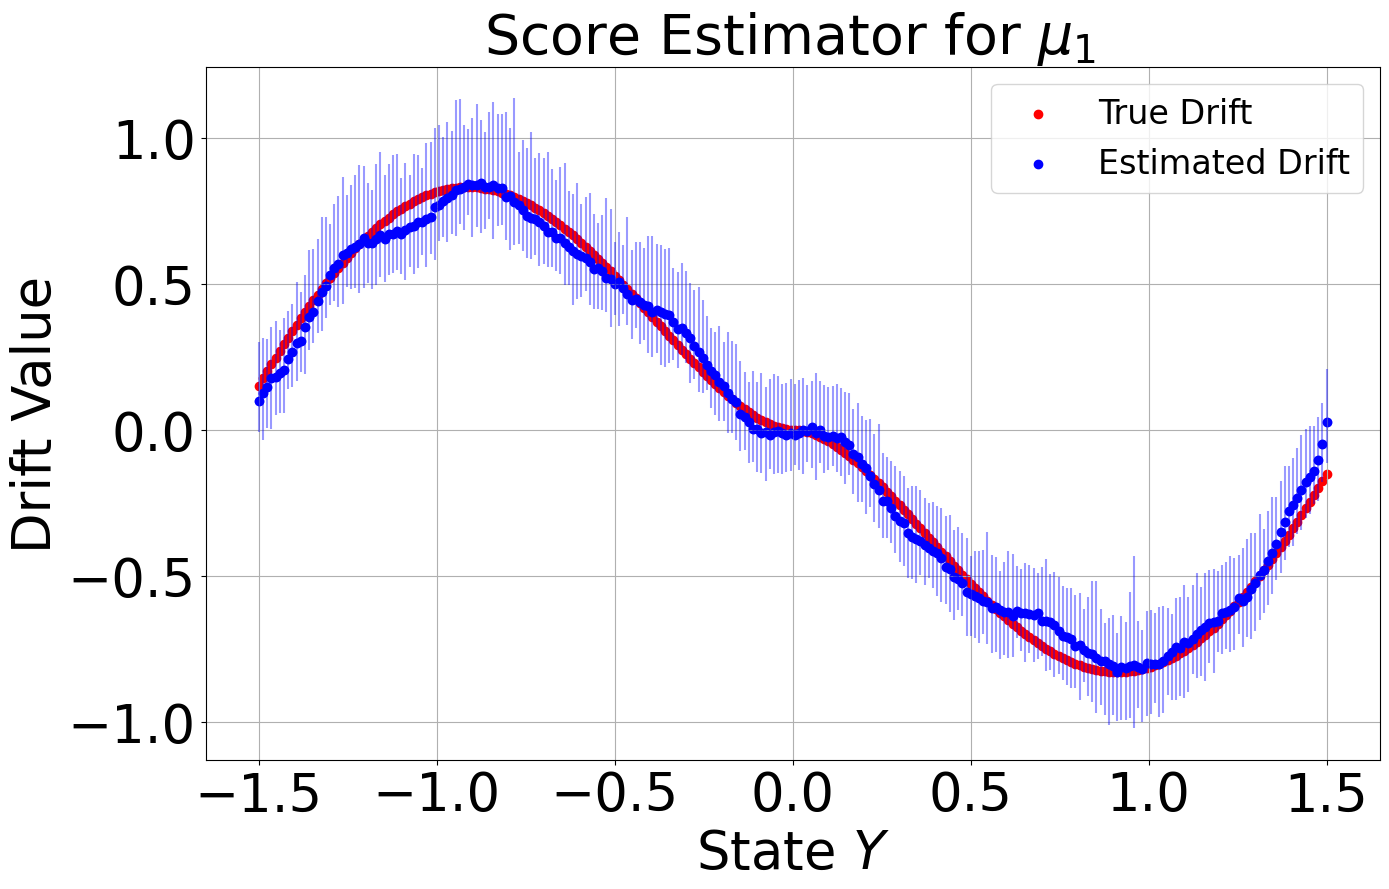

1574
(256, 100)


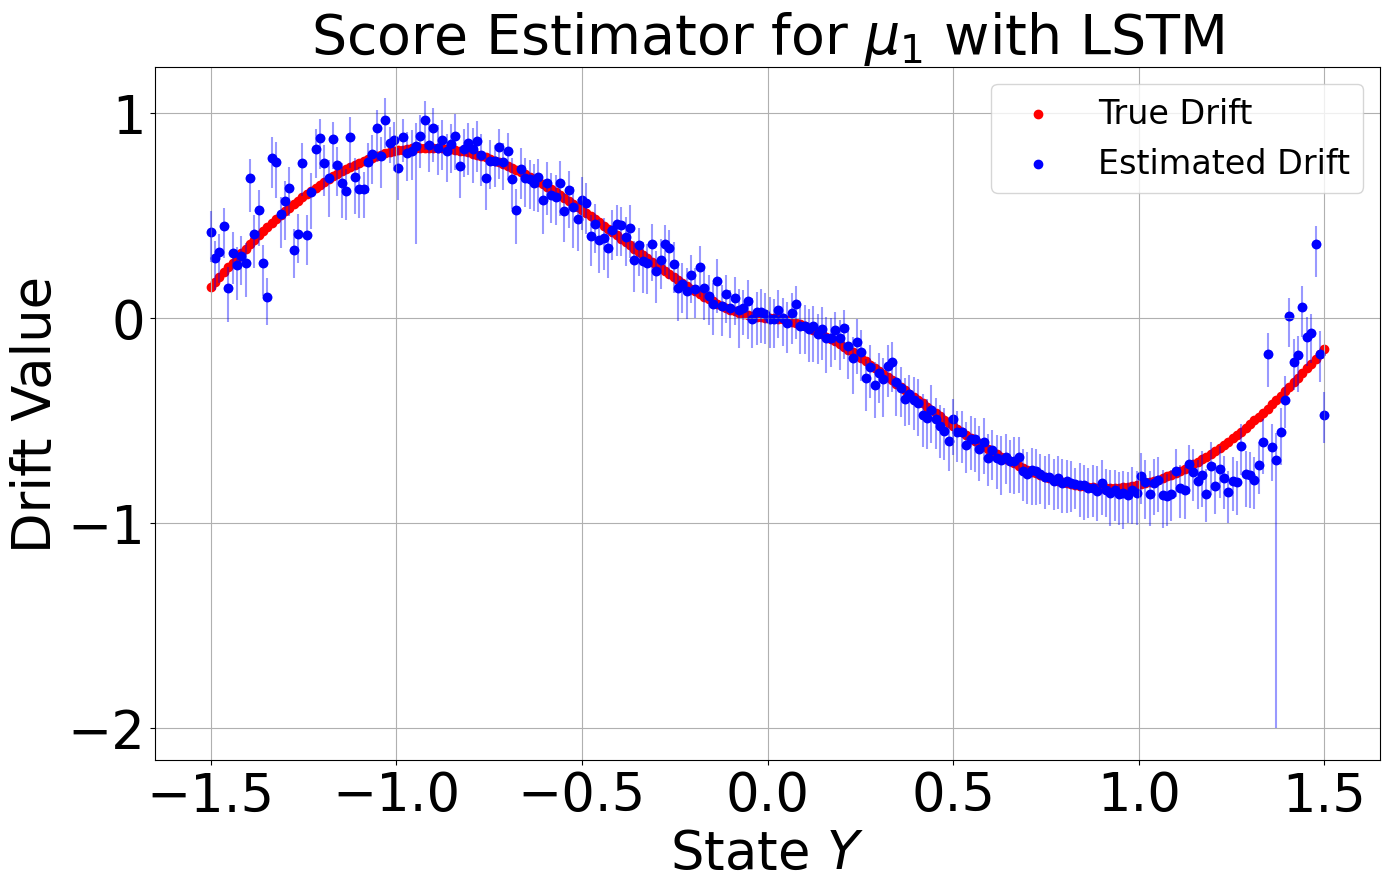

504
(256, 100)


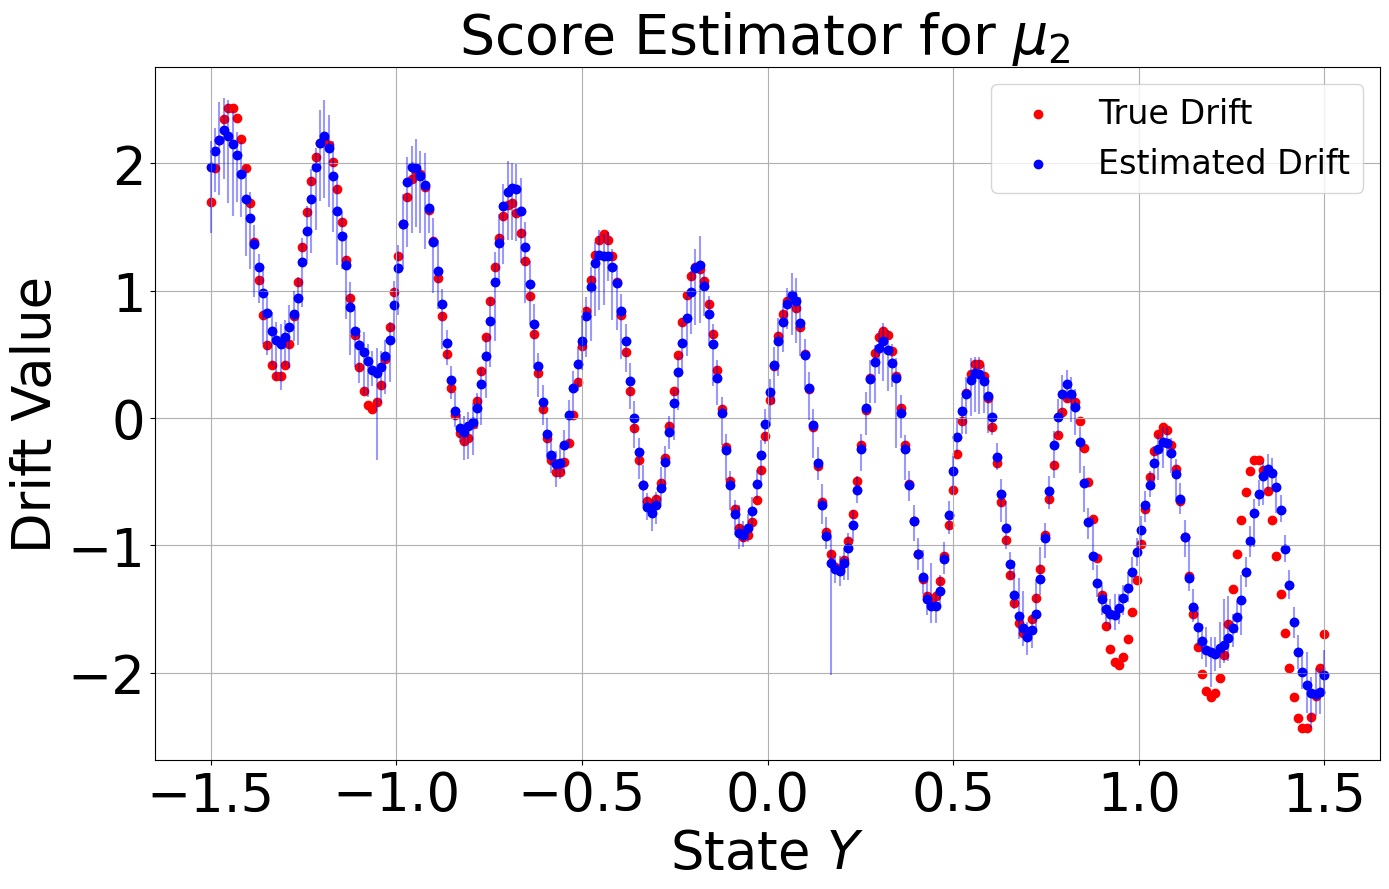

786
(256, 100)


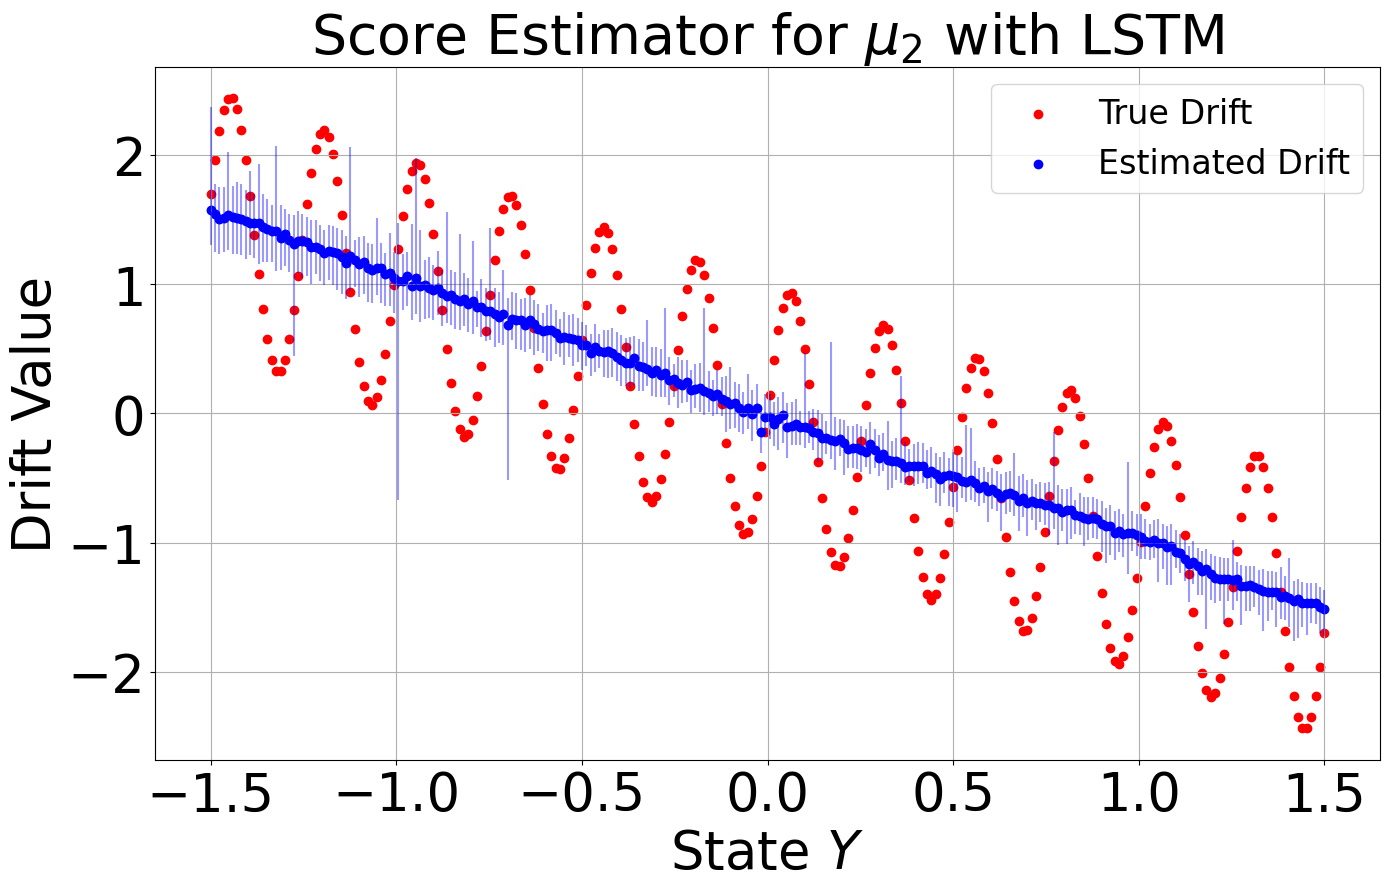

In [5]:
toSave = False
#eval_exps = {t: [np.inf] for t in ["BiPot", "QuadSinHF", "SinLog"]}
for config in [mkv_bipot_config, lstm_bipot_config, mkv_sinlog_config, lstm_sinlog_config, mkv_quadsin_config, lstm_quadsin_config]:
    Xshape = config.ts_length
    Xs = (np.linspace(-1.5,1.5,Xshape))
    root_score_dir = root_dir
    if "BiPot" in config.data_path and "MLP" in config.scoreNet_trained_path:
        true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/BiPot/"
        ts_type = "BiPot"
        label = "$\mu_{3}$"
    elif "BiPot" in config.data_path and "MLP" not in config.scoreNet_trained_path:
        true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_LSTM/BiPot/"
        ts_type = "BiPot"
        label = "$\mu_{3}$"
    elif "QuadSin" in config.data_path and "MLP" in config.scoreNet_trained_path:
        true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(config.sin_space_scale * Xs))
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/QuadSinHF/"
        ts_type = "QuadSinHF"
        label = "$\mu_{2}$"
    elif "QuadSin" in config.data_path and "MLP" not in config.scoreNet_trained_path:
        true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(config.sin_space_scale * Xs))
        root_score_dir = root_dir + f"ExperimentResults/TSPM_LSTM/QuadSinHF/"
        ts_type = "QuadSinHF"
        label = "$\mu_{2}$"
    elif "SinLog" in config.data_path and "MLP" in config.scoreNet_trained_path:
        true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/SinLog/"
        ts_type = "SinLog"
        label = "$\mu_{1}$"
    elif "SinLog" in config.data_path and "MLP" not in config.scoreNet_trained_path:
        true_drifts = (-np.sin(config.sin_space_scale*Xs)*np.log(1+config.log_space_scale*np.abs(Xs))/config.sin_space_scale)
        root_score_dir = root_dir + f"ExperimentResults/TSPM_LSTM/SinLog/"
        ts_type = "SinLog"
        label = "$\mu_{1}$"
    mse = eval_exp_pipeline(root_score_dir=root_score_dir, ts_type=ts_type, config=config, root_dir=root_dir, Xs=Xs, toSave=toSave, label=label, true_drifts=true_drifts)
